In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


```  
1. Importa las librerías necesarias para aplicar preprocesamiento de datos,
visualización y creación de un modelo de red neuronal feedforward con Keras y
Tensorflow. Importa la base de datos Customer Churn.csv y realiza el
preprocesamiento de los datos

In [60]:
# Cargar los datos
df = pd.read_csv("Customer Churn.csv")

# Mostrar los nombres de las columnas originales
print("Nombres de las columnas originales:")
print(df.columns)

# Limpiar los nombres de las columnas eliminando todos los espacios adicionales
df.columns = [col.replace(" ", "") for col in df.columns]

# Verificar los nombres de las columnas después de la limpieza
print("Nombres de las columnas después de la limpieza:")
print(df.columns)

Nombres de las columnas originales:
Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')
Nombres de las columnas después de la limpieza:
Index(['CallFailure', 'Complains', 'SubscriptionLength', 'ChargeAmount',
       'SecondsofUse', 'Frequencyofuse', 'FrequencyofSMS',
       'DistinctCalledNumbers', 'AgeGroup', 'TariffPlan', 'Status', 'Age',
       'CustomerValue', 'Churn'],
      dtype='object')


``` 
2. Analiza la distribución de “Subscription Length” para cada clase (Churn),
describiendo si hay alguna incidencia de esta variable en la renuncia o no. Realiza
una estandarización de las variables regresoras

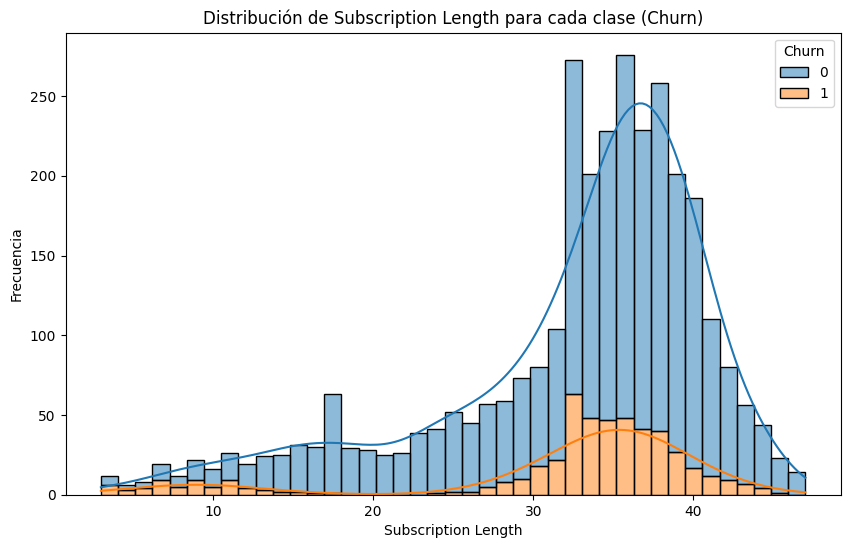

In [54]:
# Analizar la distribución de "SubscriptionLength"
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="SubscriptionLength", hue="Churn", multiple="stack", kde=True)
plt.title("Distribución de Subscription Length para cada clase (Churn)")
plt.xlabel("Subscription Length")
plt.ylabel("Frecuencia")
plt.show()

``` 
3. Muestra la frecuencia de cada clase y realiza un balanceo de clase usando SMOTE.
Divida el conjunto de datos en entrenamiento y test, considerando para este último
un 33%.

In [61]:
# Estandarizar las variables regresoras
features = [
    "CallFailure",
    "Complains",
    "SubscriptionLength",
    "ChargeAmount",
    "SecondsofUse",
    "Frequencyofuse",
    "FrequencyofSMS",
    "DistinctCalledNumbers",
    "AgeGroup",
    "TariffPlan",
    "Status",
    "CustomerValue",
]
X = df[features]
y = df["Churn"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [62]:
# Mostrar la frecuencia de cada clase
print("Frecuencia de cada clase antes del balanceo:", Counter(y))

# Realizar el balanceo de clases usando SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("Frecuencia de cada clase después del balanceo:", Counter(y_res))

# Dividir el conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.33, random_state=42
)

Frecuencia de cada clase antes del balanceo: Counter({0: 2655, 1: 495})
Frecuencia de cada clase después del balanceo: Counter({0: 2655, 1: 2655})


``` 
4. Entrene un modelo RandomForest con hiper parámetros por defecto, usando el
conjunto de entrenamiento anterior y muestra la métrica F1-Score para ambas
clases en el conjunto de test. Captura y muestra las siete características más
importantes detectadas por el modelo RandomForest.

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       874
           1       0.97      0.97      0.97       879

    accuracy                           0.97      1753
   macro avg       0.97      0.97      0.97      1753
weighted avg       0.97      0.97      0.97      1753

F1-Score para la clase 0: 0.9712973593570609
F1-Score para la clase 1: 0.971655328798186


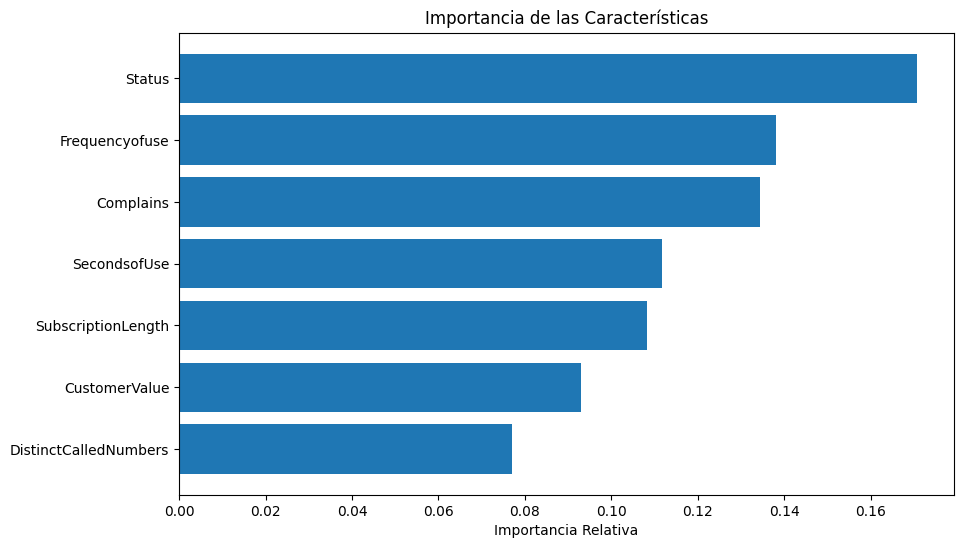

Siete características más importantes: ['DistinctCalledNumbers', 'CustomerValue', 'SubscriptionLength', 'SecondsofUse', 'Complains', 'Frequencyofuse', 'Status']


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Entrenar un modelo RandomForest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predicciones y métricas en el conjunto de prueba
y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1-Score para la clase 0:", f1_score(y_test, y_pred, pos_label=0))
print("F1-Score para la clase 1:", f1_score(y_test, y_pred, pos_label=1))

# Capturar y mostrar las siete características más importantes
importances = rf.feature_importances_
indices = np.argsort(importances)[-7:]

plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Importancia Relativa")
plt.show()

# Características más importantes
important_features = [features[i] for i in indices]
print("Siete características más importantes:", important_features)

``` 
5. Usando las siete características encontradas anteriormente, filtra el conjunto de
entrenamiento y entrena un modelo de red neuronal feedforward con sólo una capa
oculta. Para esto debes definir una función de activación adecuada, tanto para la
capa oculta como para la capa de salida, la cantidad de neuronas a usar, la tasa de
aprendizaje (learning_rate), y la cantidad de épocas deben ser ajustadas
manualmente. Como optimizador, utiliza el Descenso del Gradiente Estocástico. Los
ajustes manuales de los hiper parámetros deben ser tales que la métrica AUC sea
mayor al 90%. Muestra finalmente ROC y su AUC.

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.9451295548561268


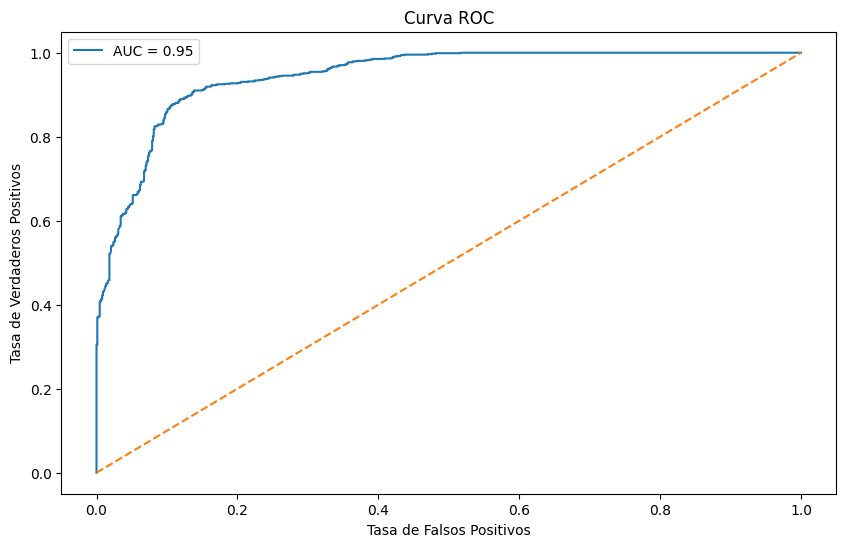

In [59]:
# Filtrar el conjunto de entrenamiento con las características más importantes
X_train_imp = X_train[:, indices]
X_test_imp = X_test[:, indices]

# Crear y entrenar el modelo de red neuronal
model = Sequential()
model.add(Dense(15, input_dim=X_train_imp.shape[1], activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Compilar el modelo
model.compile(
    optimizer=SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["AUC"]
)

# Entrenar el modelo
history = model.fit(
    X_train_imp, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0
)

# Evaluar el modelo
y_pred_prob = model.predict(X_test_imp).ravel()
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

# Mostrar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="best")
plt.show()